#### Title: 
Analysis of Breast Cancer Dataset

#### Description: 
This project analyzes a breast cancer dataset using a multilayer perceptron algorithm. Using 10-fold cross-validation we will tune the hyperparameters to optimize the model performance and accuracy and minimize training error. Then, we will evaluate the results in terms of bias-variance tradeoffs and argue how properties of the data impact the tradeoff. Finally, we will analyze the optimized model to extract insights into how input attributes correlate with the classification results.

---

### Importing the data

In [29]:
import pandas as pd
import numpy as np

# Column names
col_names = ['Sample code number', 'Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses', 'Class']
# Load the data
data = pd.read_csv('breast-cancer-wisconsin.data', header=None, names=col_names)
# Shape of the data
print('Shape of the data: ', data.shape)

Shape of the data:  (699, 11)


### Showing one random data sample

In [30]:
# Get one random data sample
random_sample = data.sample(1)
# Print the sample
print(random_sample)

     Sample code number  Clump Thickness  Uniformity of Cell Size  \
584             1217717                5                        1   

     Uniformity of Cell Shape  Marginal Adhesion  Single Epithelial Cell Size  \
584                         1                  6                            3   

    Bare Nuclei  Bland Chromatin  Normal Nucleoli  Mitoses  Class  
584           1                1                1        1      2  


### Visualizing the data distribution

Class
2    458
4    241
dtype: int64


[Text(0, 0, 'Class 0 - Benign'), Text(1, 0, 'Class 1- Malignant')]

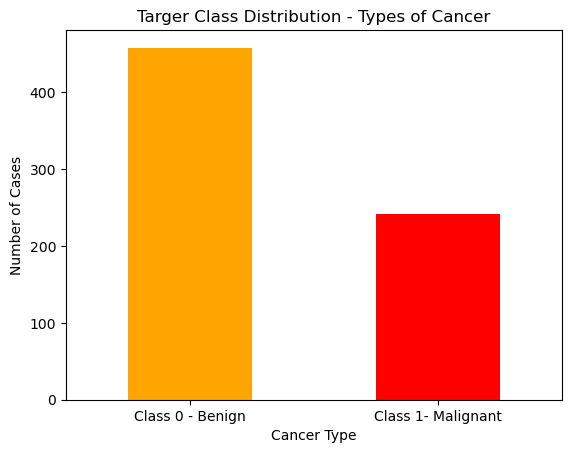

In [31]:
# Count the number of cases for each cancer type
grouped_data = data.groupby('Class').size()
print(grouped_data)
# Plot it
plot = grouped_data.plot(kind='bar', title='Targer Class Distribution - Types of Cancer', color=['orange', 'red'])
plot.set_xlabel('Cancer Type')
plot.set_ylabel('Number of Cases')
plot.set_xticklabels(['Class 0 - Benign', 'Class 1- Malignant'], rotation=0)



### Pre-processing the data

In [32]:
from sklearn.preprocessing import StandardScaler

# Check for missing values in the data - they are represented by '?'
print('Number of missing values: ', data[data == '?'].count().sum())
# Replace the missing values with the mode of the column
data = data.replace('?', data.mode().iloc[0])
# Check if there are any missing values left
print('Number of missing values: ', data[data == '?'].count().sum())

# Shuffle the data to remove bias
data = data.sample(frac=1).reset_index(drop=True)

# Split the data into features and target
x = data.drop('Class', axis=1)
y = data['Class']

# Romove the sample code number column as it is not useful for the model
x = x.drop('Sample code number', axis=1)

# Scale the features to improve model performance
# scaler = StandardScaler()
# x = scaler.fit_transform(x)

# Convert the target labels to binary
# 1 -> Malignant
# 0 -> Benign
y = np.where(y == 4, 1, 0)
print('First 10 target labels: ', y[:10])

Number of missing values:  16
Number of missing values:  0
First 10 target labels:  [1 0 1 1 0 0 0 0 1 1]


### Splitting the data into train and test

In [33]:

from sklearn.model_selection import train_test_split
# Split the data into training and testing sets - 80% training, 20% testing
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)
x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
# Print the shapes of the training and testing sets
print('Shape of the training set: ', x_train.shape, y_train.shape)
print('Shape of the testing set: ', x_test.shape, y_test.shape)

Shape of the training set:  (559, 9) (559,)
Shape of the testing set:  (140, 9) (140,)


### Creating a function for plotting the learning results

In [34]:
import matplotlib.pyplot as plt

def plot_results(history, fold):
  # Get the highest validation accuracy.
  best_validation_accuracy = max(history['val_accuracy'])

  # Plot the accuracy vs. epoch.
  # Highlight the highest validation accuracy.
  # The y axis is set to the range 0 to 1.
  plt.plot(history['accuracy'])
  plt.plot(history['val_accuracy'])
  plt.title('Accuracy - (Fold {})'.format(fold))
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.axhline(y=best_validation_accuracy, color='g', linestyle=('dotted'))
  plt.legend(['Training', 'Validation', 'Best Validation Accuracy'], loc='lower right')
  plt.text(0, best_validation_accuracy, str(round(best_validation_accuracy, 4)))
  plt.show()

  # Plot the loss vs. epoch.
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.title('Loss ')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Validation'], loc='upper right')
  plt.show()

### Implementing the model

In [35]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import GlorotUniform

# Set the seed for reproducibility
np.random.seed(1)
# Number of epochs
epochs = 30
# Loss function
loss_function = 'binary_crossentropy'
# Metrics
metrics = ['accuracy']

def get_model(learning_rate=0.001, dropout_rate=0.1, num_layers=1, num_neurons=10):
  # Define Adam optimizer with given learning rate
  optimizer = Adam(learning_rate=learning_rate)
  # Define Dropout layer
  dropout = Dropout(dropout_rate)
  # Make sure the model is run on the GPU.
  tf.config.set_visible_devices([], 'GPU')
  with tf.device('/gpu:0'):
    # Create the model
    model = Sequential()
    # Add the input layer
    model.add(Dense(num_neurons, input_dim=9, activation='relu'))
    model.add(dropout)
    for i in range(num_layers):
      # Add hidden layers
      model.add(Dense(num_neurons, activation='relu'))
      model.add(dropout)
    model.add(Dense(num_neurons, activation='relu'))
    # Add the output layer
    model.add(Dense(1, activation='sigmoid'))
    # Compile the model
    model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)
    # Return the model
    return model

### Evaluating the bias-variance by training different models

In [36]:
batch_size_small = 16
batch_size_medium = 64
batch_size_large = 128
avg_losses_small = []
avg_losses_medium = []
avg_losses_large = []
avg_biases_small = []
avg_biases_medium = []
avg_biases_large = []
avg_variances_small = []
avg_variances_medium = []
avg_variances_large = []

In [37]:
# Hyperparameters for different models
models = {

    1: {
        'learning_rate': 0.0001,
        'dropout_rate': 0.01,
        'num_layers': 0,
        'num_neurons': 5
    },
    2: {
        'learning_rate': 0.001,
        'dropout_rate': 0.1,
        'num_layers': 1,
        'num_neurons': 10
    },
    3: {
        'learning_rate': 0.001,
        'dropout_rate': 0.1,
        'num_layers': 2,
        'num_neurons': 20,
    },
    4: {
        'learning_rate': 0.005,
        'dropout_rate': 0.05,
        'num_layers': 1,
        'num_neurons': 10
    },
    5: {
        'learning_rate': 0.01,
        'dropout_rate': 0.1,
        'num_layers': 1,
        'num_neurons': 10
    },
    6: {
        'learning_rate': 0.1,
        'dropout_rate': 0.5,
        'num_layers': 2,
        'num_neurons': 30
    }
}

In [38]:
def eval_bias_variance(batch_size, learning_rate, dropout_rate, num_layers, num_neurons):
  test_model = get_model(learning_rate=learning_rate, dropout_rate=dropout_rate, num_layers=num_layers, num_neurons=num_neurons)
  test_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
  predictions = test_model.predict(x_test, verbose=0)
  # Calculate bias
  y_true_mean = np.mean(y_test)
  bias = abs(np.mean(predictions) - y_true_mean) 
  # Calculate variance
  variance = abs(np.var(predictions))
  # Calculate loss
  loss, accuracy = test_model.evaluate(x_test, y_test, verbose=0)

  print('Average expected loss: %.3f' % loss)
  print('Average bias: %.3f' % bias)
  print('Average variance: %.3f' % variance)
  return loss, bias, variance

In [39]:
def eval_model(learning_rate, dropout_rate, num_layers, num_neurons):
  loss, bias, variance = eval_bias_variance(batch_size_small, learning_rate, dropout_rate, num_layers, num_neurons)
  avg_losses_small.append(loss)
  avg_biases_small.append(bias)
  avg_variances_small.append(variance)
  loss, bias, variance = eval_bias_variance(batch_size_medium, learning_rate, dropout_rate, num_layers, num_neurons)
  avg_losses_medium.append(loss)
  avg_biases_medium.append(bias)
  avg_variances_medium.append(variance)
  loss, bias, variance = eval_bias_variance(batch_size_large, learning_rate, dropout_rate, num_layers, num_neurons)
  avg_losses_large.append(loss)
  avg_biases_large.append(bias)
  avg_variances_large.append(variance)

def eval_model_by_id(i):
  eval_model(models[i]['learning_rate'], models[i]['dropout_rate'], models[i]['num_layers'], models[i]['num_neurons'])

### Model 1

In [40]:
eval_model_by_id(1)

Average expected loss: 0.886
Average bias: 0.120
Average variance: 0.052
Average expected loss: 0.618
Average bias: 0.222
Average variance: 0.013
Average expected loss: 1.225
Average bias: 0.079
Average variance: 0.025


### Model 2

In [41]:
eval_model_by_id(2)

Average expected loss: 0.181
Average bias: 0.008
Average variance: 0.184
Average expected loss: 0.583
Average bias: 0.016
Average variance: 0.005
Average expected loss: 0.398
Average bias: 0.122
Average variance: 0.073


### Model 3

In [42]:
eval_model_by_id(3)

Average expected loss: 0.157
Average bias: 0.016
Average variance: 0.202
Average expected loss: 0.225
Average bias: 0.025
Average variance: 0.190
Average expected loss: 0.263
Average bias: 0.061
Average variance: 0.165


### Model 4

In [43]:
eval_model_by_id(4)

Average expected loss: 0.127
Average bias: 0.021
Average variance: 0.202
Average expected loss: 0.133
Average bias: 0.015
Average variance: 0.206
Average expected loss: 0.177
Average bias: 0.006
Average variance: 0.198


### Model 5

In [44]:
eval_model_by_id(5)

Average expected loss: 0.121
Average bias: 0.009
Average variance: 0.210
Average expected loss: 0.186
Average bias: 0.029
Average variance: 0.192
Average expected loss: 0.128
Average bias: 0.005
Average variance: 0.191


### Model 6

In [45]:
eval_model_by_id(6)

Average expected loss: 0.670
Average bias: 0.066
Average variance: 0.000
Average expected loss: 0.665
Average bias: 0.050
Average variance: 0.000
Average expected loss: 0.342
Average bias: 0.043
Average variance: 0.064


### Summary of the models

In [53]:
# Print the summary of the evaluated models and their hyperparameters
def print_model_summary(i):
  print('Model {} summary:'.format(i))
  print('Learning rate: {}'.format(models[i]['learning_rate']))
  print('Dropout rate: {}'.format(models[i]['dropout_rate']))
  print('Number of layers: {}'.format(models[i]['num_layers']))
  print('Number of neurons: {}'.format(models[i]['num_neurons']))
  # Calculate the average loss, bias and variance for each batch size (small, medium, large)
  avg_loss = (avg_losses_small[i-1] + avg_losses_medium[i-1] + avg_losses_large[i-1]) / 3
  avg_bias = (avg_biases_small[i-1] + avg_biases_medium[i-1] + avg_biases_large[i-1]) / 3
  avg_variance = (avg_variances_small[i-1] + avg_variances_medium[i-1] + avg_variances_large[i-1]) / 3
  print('Average loss: {}'.format(round(avg_loss, 3)))
  print('Average bias: {}'.format(round(avg_bias, 3)))
  print('Average variance: {}'.format(round(avg_variance, 3)))
  print('Average loss + bias + variance: {}'.format(round(avg_loss + avg_bias + avg_variance, 3)))


In [55]:
print_model_summary(1)

Model 1 summary:
Learning rate: 0.0001
Dropout rate: 0.01
Number of layers: 0
Number of neurons: 5
Average loss: 0.91
Average bias: 0.14
Average variance: 0.03
Average loss + bias + variance: 1.08


In [56]:
print_model_summary(2)

Model 2 summary:
Learning rate: 0.001
Dropout rate: 0.1
Number of layers: 1
Number of neurons: 10
Average loss: 0.387
Average bias: 0.049
Average variance: 0.088
Average loss + bias + variance: 0.523


In [57]:
print_model_summary(3)

Model 3 summary:
Learning rate: 0.001
Dropout rate: 0.1
Number of layers: 2
Number of neurons: 20
Average loss: 0.215
Average bias: 0.034
Average variance: 0.186
Average loss + bias + variance: 0.435


In [58]:
print_model_summary(4)

Model 4 summary:
Learning rate: 0.005
Dropout rate: 0.05
Number of layers: 1
Number of neurons: 10
Average loss: 0.146
Average bias: 0.014
Average variance: 0.202
Average loss + bias + variance: 0.362


In [59]:
print_model_summary(5)

Model 5 summary:
Learning rate: 0.01
Dropout rate: 0.1
Number of layers: 1
Number of neurons: 10
Average loss: 0.145
Average bias: 0.014
Average variance: 0.198
Average loss + bias + variance: 0.357


In [60]:
print_model_summary(6)

Model 6 summary:
Learning rate: 0.1
Dropout rate: 0.5
Number of layers: 2
Number of neurons: 30
Average loss: 0.559
Average bias: 0.053
Average variance: 0.021
Average loss + bias + variance: 0.633


### Plot the average loss, bias, and variance

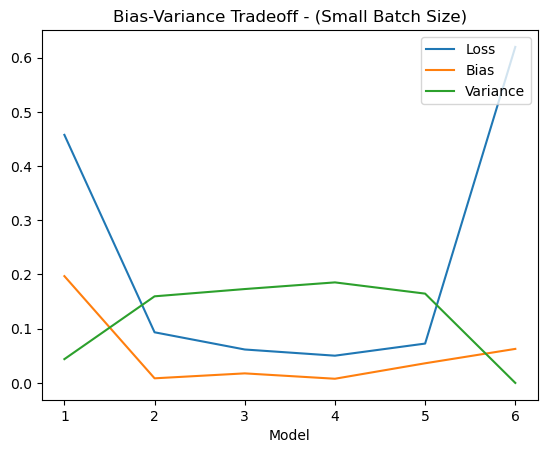

In [50]:
plt.plot(avg_losses_small)
plt.plot(avg_biases_small)
plt.plot(avg_variances_small)
plt.title('Bias-Variance Tradeoff - (Small Batch Size)')
plt.xlabel('Model')
plt.xticks(range(6), range(1, 7))
plt.legend(['Loss', 'Bias', 'Variance'], loc='upper right')
plt.show()

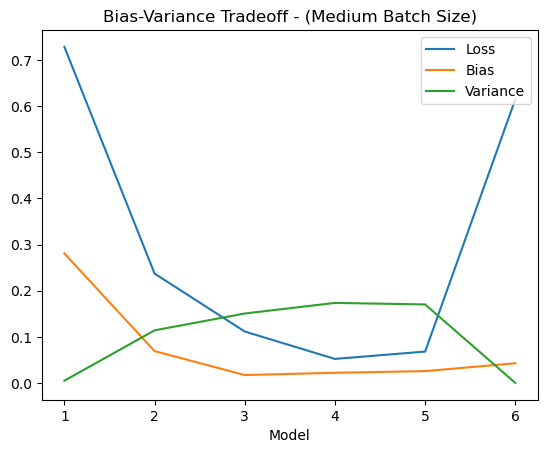

In [51]:
plt.plot(avg_losses_medium)
plt.plot(avg_biases_medium)
plt.plot(avg_variances_medium)
plt.title('Bias-Variance Tradeoff - (Medium Batch Size)')
plt.xlabel('Model')
plt.xticks(range(6), range(1, 7))
plt.legend(['Loss', 'Bias', 'Variance'], loc='upper right')
plt.show()

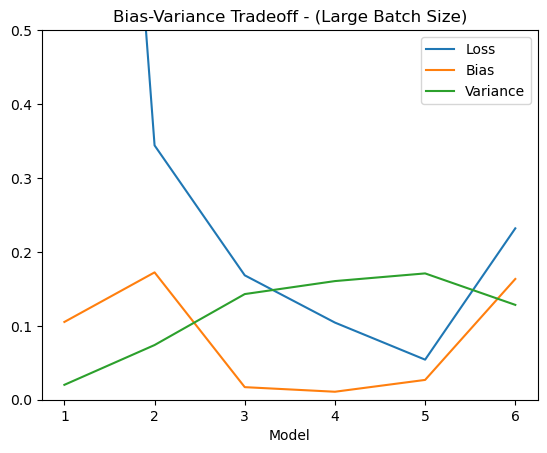

In [52]:
plt.plot(avg_losses_large)
plt.plot(avg_biases_large)
plt.plot(avg_variances_large)
plt.title('Bias-Variance Tradeoff - (Large Batch Size)')
plt.xlabel('Model')
plt.xticks(range(6), range(1, 7))
plt.ylim(0, 0.5)
plt.legend(['Loss', 'Bias', 'Variance'], loc='upper right')
plt.show()

### Validating the optimal model on the training data using 10-fold cross validation

No. of validation samples:  55
Validation data shape:  (55, 9) (55,)
Training data shape:  (504, 9) (504,)
Validation accuracy for fold 1: 0.8909090757369995


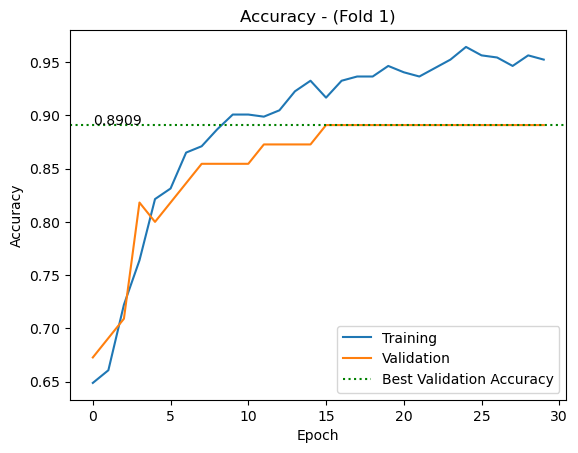

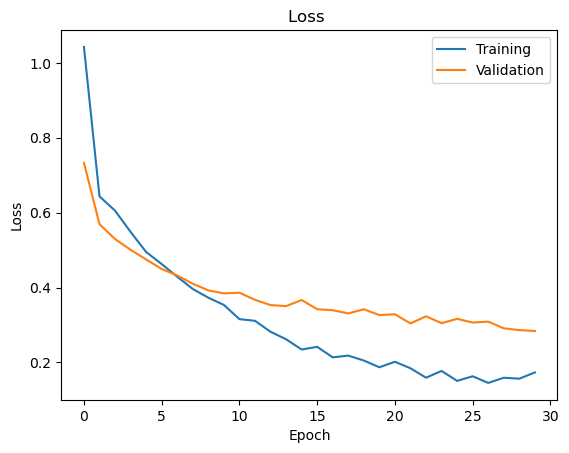

Validation accuracy for fold 2: 0.9636363387107849


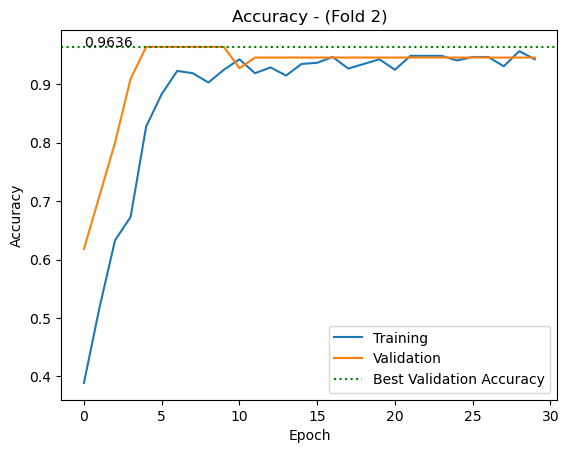

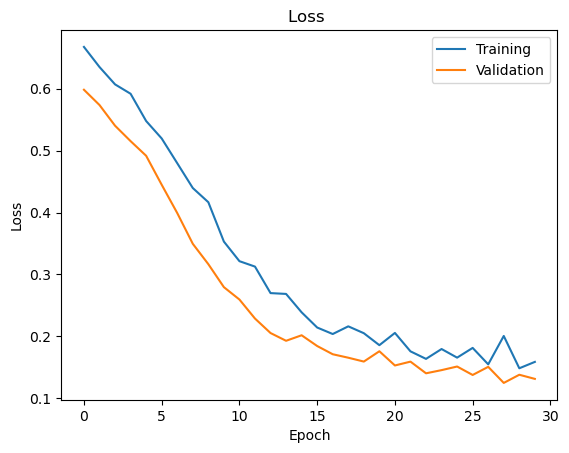

Validation accuracy for fold 3: 0.9636363387107849


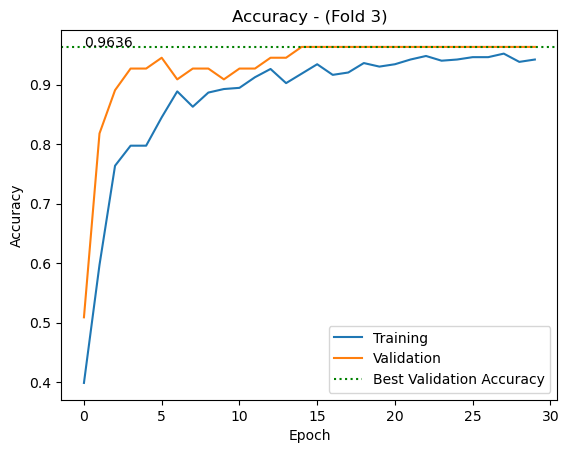

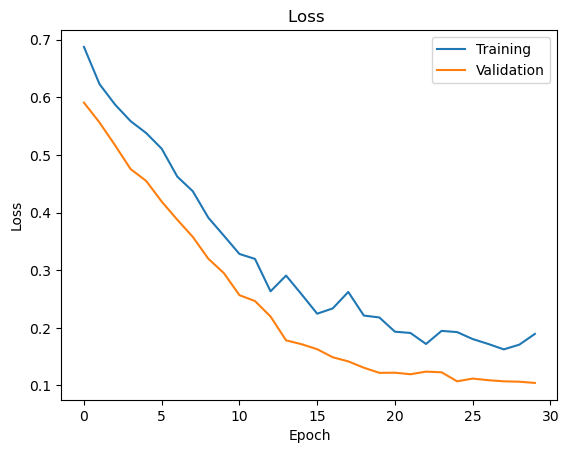

Validation accuracy for fold 4: 0.9636363387107849


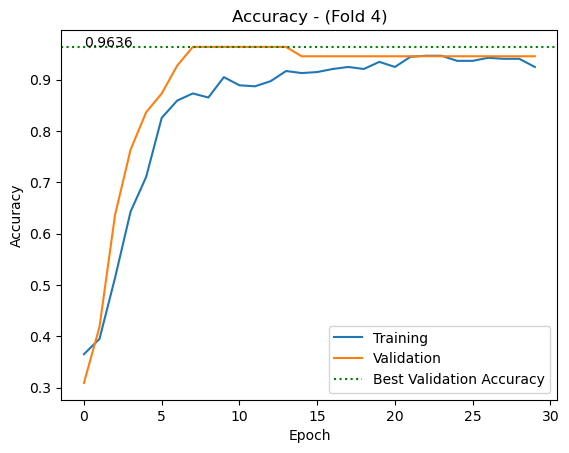

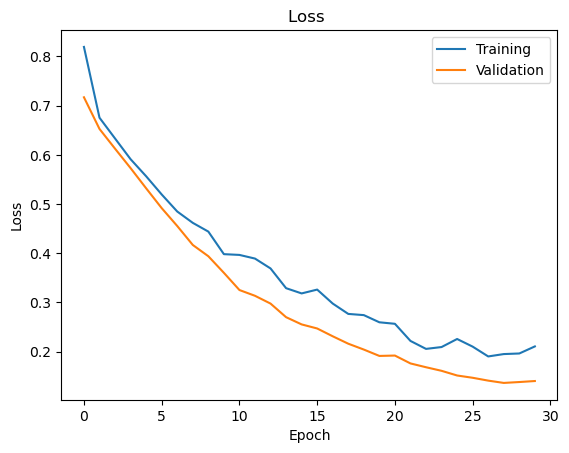

Validation accuracy for fold 5: 0.9454545378684998


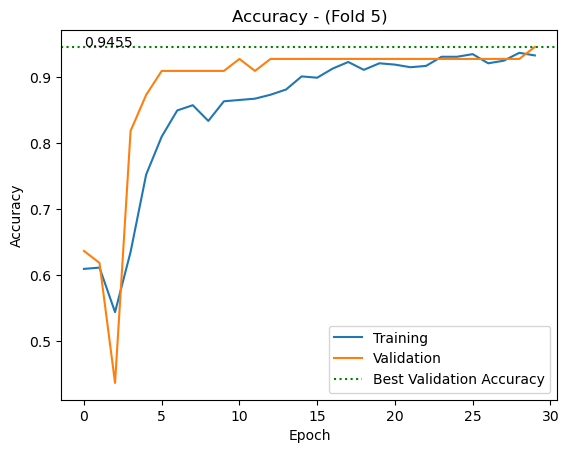

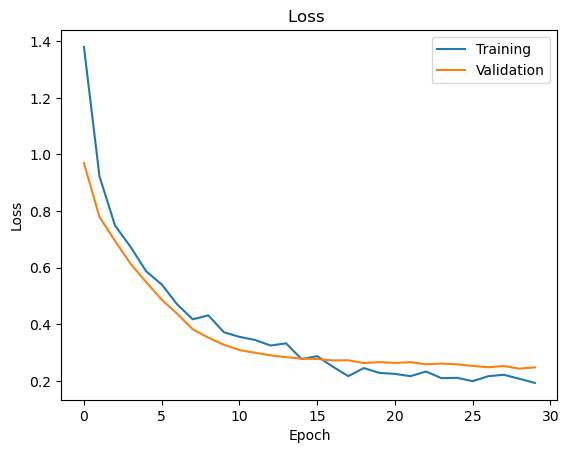

Validation accuracy for fold 6: 0.9636363387107849


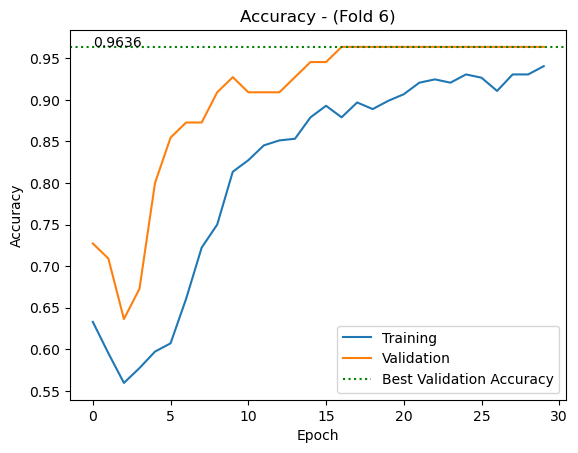

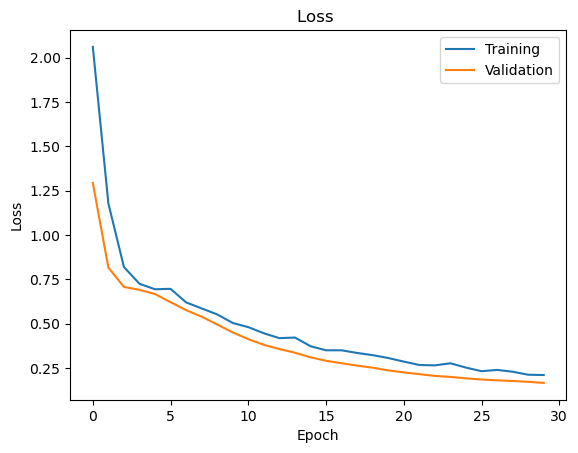

Validation accuracy for fold 7: 1.0


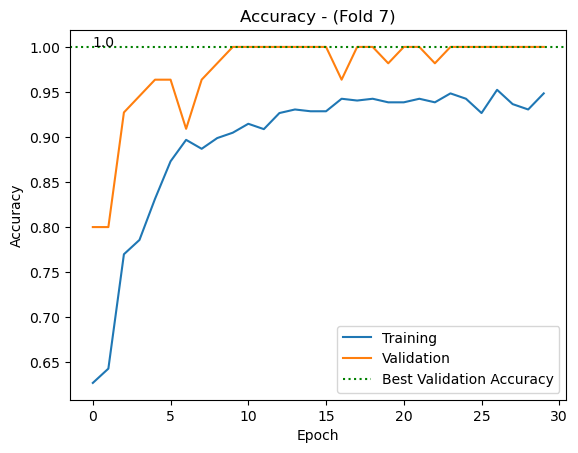

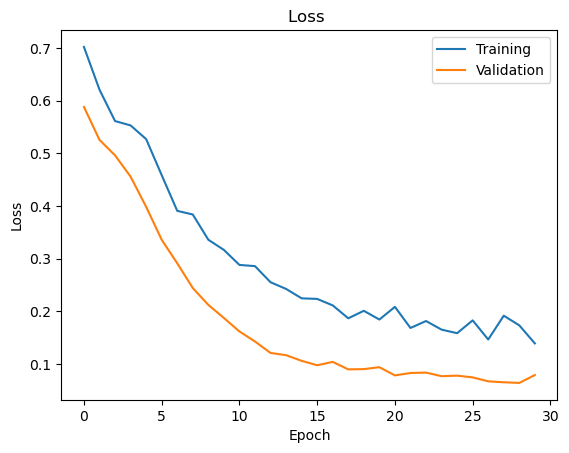

Validation accuracy for fold 8: 0.9818181991577148


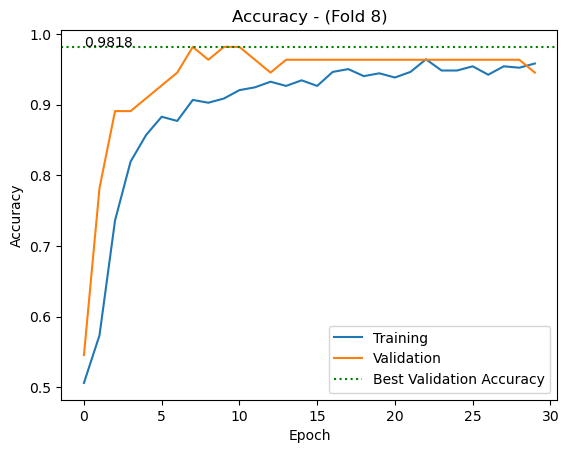

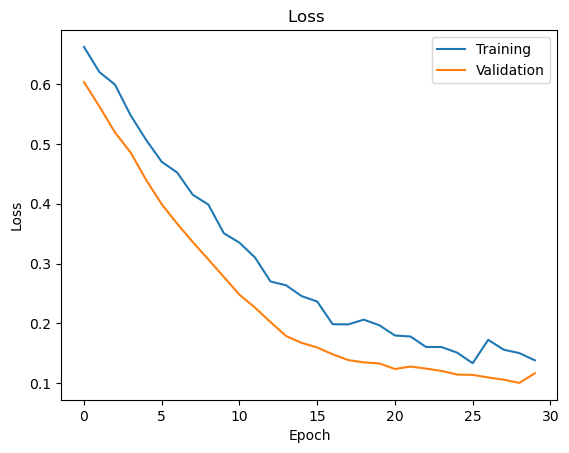

Validation accuracy for fold 9: 0.9636363387107849


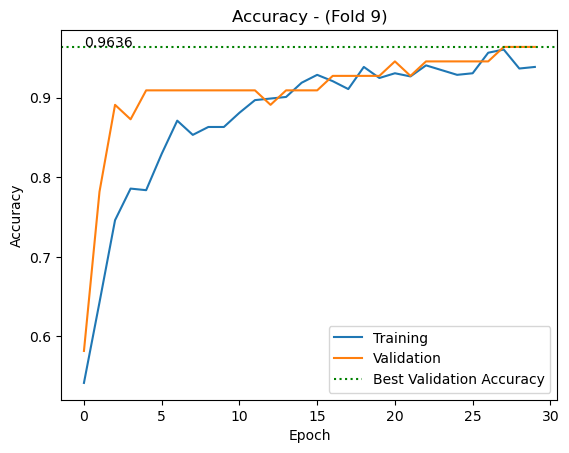

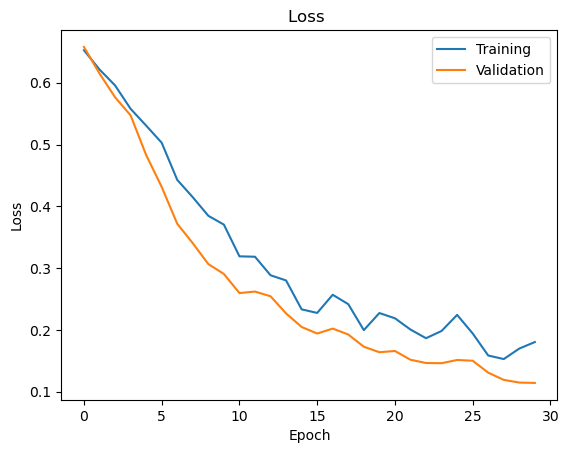

Validation accuracy for fold 10: 0.9818181991577148


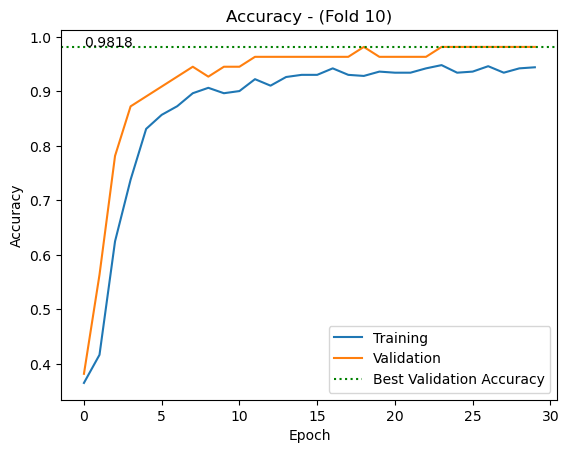

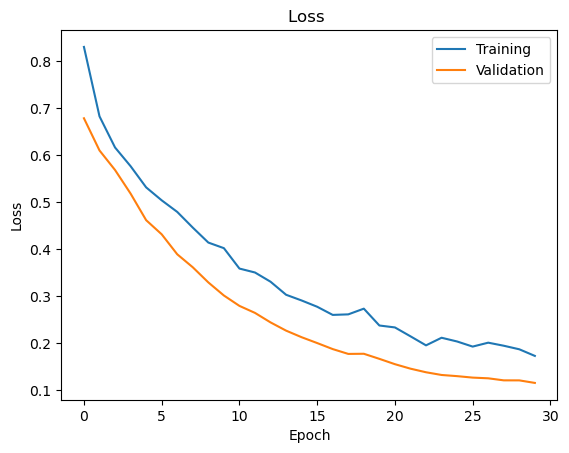

In [54]:
# Number of folds
k = 10
# Number of validation samples
val_samples = len(x_train) // k 
print('No. of validation samples: ', val_samples)
validation_scores = []
# 10-fold cross validation loop
for fold in range(k):
  # Get a validation fold by taking a slice of the training data. The slice has a size of val_samples.
  val_fold_x = x_train[val_samples * fold:val_samples * (fold + 1)]
  val_fold_y = y_train[val_samples * fold:val_samples * (fold + 1)]
  # Get the training data by taking all the samples before the validation fold and appending all the samples after the validation fold.
  train_fold_x = np.concatenate([x_train[:val_samples * fold], x_train[val_samples * (fold + 1):]])
  train_fold_y = np.concatenate([y_train[:val_samples * fold], y_train[val_samples * (fold + 1):]])
  if (fold == 0):
    print('Validation data shape: ', val_fold_x.shape, val_fold_y.shape)
    print('Training data shape: ', train_fold_x.shape, train_fold_y.shape)
  # Create new instance of the model
  model = get_model()
  # Train the model
  result = model.fit(train_fold_x, train_fold_y, epochs=epochs, batch_size=batch_size_small, validation_data=(val_fold_x, val_fold_y), verbose=0)
  # Evaluate the model
  validiation_accuracy = max(result.history['val_accuracy'])
  print('Validation accuracy for fold {}: {}'.format(fold + 1, validiation_accuracy))
  validation_scores.append(validiation_accuracy)
  # Plot the training history for current fold
  plot_results(result.history, fold + 1)

### Finding the average accurary across all 10 folds

[0.8909090757369995, 0.9636363387107849, 0.9636363387107849, 0.9636363387107849, 0.9454545378684998, 0.9636363387107849, 1.0, 0.9818181991577148, 0.9636363387107849, 0.9818181991577148]


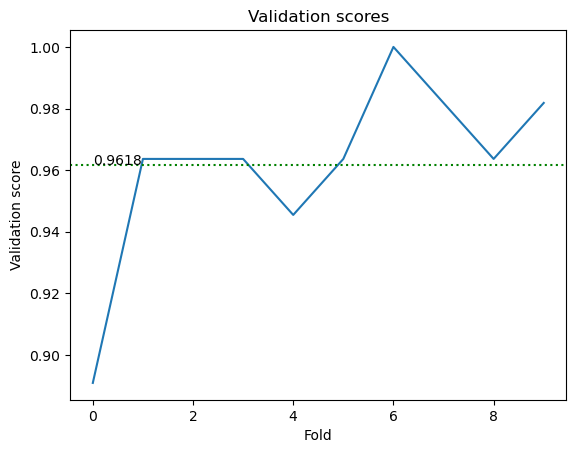

In [55]:
import matplotlib.pyplot as plt
# Final validation score (average of the 10 validation scores)
validation_score = np.average(validation_scores)
# Plot the final validation scores
print(validation_scores)
plt.plot(validation_scores)
plt.title('Validation scores')
plt.ylabel('Validation score')
plt.xlabel('Fold')
plt.axhline(y=validation_score, color='g', linestyle=('dotted'))
plt.text(0, validation_score, str(round(validation_score, 4)))
plt.show()

### Training the optimal model on the whole training set

In [56]:
final_model = get_model()
final_model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size_small, verbose=1)

Epoch 1/30
35/35 [==============================] - 1s 1ms/step - loss: 0.6222 - accuracy: 0.3882
Epoch 2/30
35/35 [==============================] - 0s 1ms/step - loss: 0.5708 - accuracy: 0.6547
Epoch 3/30
35/35 [==============================] - 0s 1ms/step - loss: 0.5235 - accuracy: 0.8354
Epoch 4/30
35/35 [==============================] - 0s 1ms/step - loss: 0.4456 - accuracy: 0.8945
Epoch 5/30
35/35 [==============================] - 0s 1ms/step - loss: 0.3921 - accuracy: 0.8855
Epoch 6/30
35/35 [==============================] - 0s 2ms/step - loss: 0.3619 - accuracy: 0.8855
Epoch 7/30
35/35 [==============================] - 0s 2ms/step - loss: 0.2958 - accuracy: 0.9052
Epoch 8/30
35/35 [==============================] - 0s 1ms/step - loss: 0.2758 - accuracy: 0.8998
Epoch 9/30
35/35 [==============================] - 0s 1ms/step - loss: 0.2539 - accuracy: 0.9159
Epoch 10/30
35/35 [==============================] - 0s 1ms/step - loss: 0.2503 - accuracy: 0.9141
Epoch 11/30
35/35 [

### Evaluating the model performance on the test set

5/5 [==============================] - 0s 1ms/step - loss: 0.0829 - accuracy: 0.9714


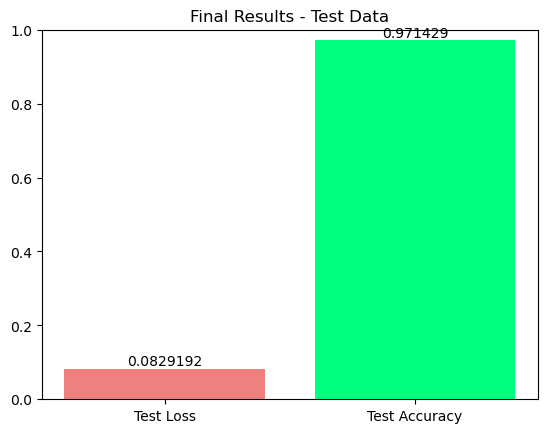

In [57]:
import seaborn as sns

# Get the evaluation metrics for the final model on the test data.
test_loss, test_accuracy = final_model.evaluate(x_test, y_test)

# Plot the final results - test loss and test accuracy.
fig, ax = plt.subplots()
bars = ax.bar(['Test Loss', 'Test Accuracy'], [test_loss, test_accuracy], color=['lightcoral', 'springgreen'])
ax.bar_label(bars)
ax.set_title('Final Results - Test Data')
ax.set_ylim(0, 1)
plt.show()

### Plotting the confusion matrix

5/5 [==============================] - 0s 998us/step


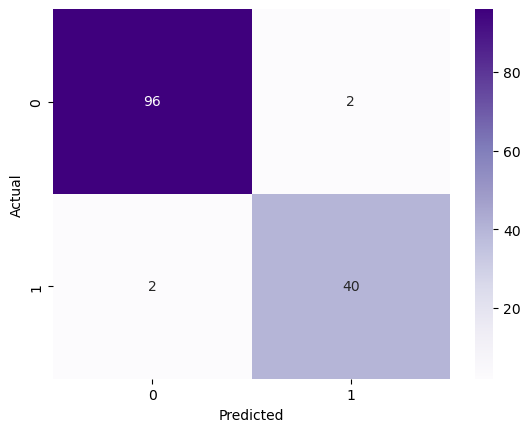

In [58]:
import matplotlib.colors as colors
# Make predictions on the test data.
predictions = final_model.predict(x_test)
# Convert prediction values to class labels
y_predictions = np.round(predictions)
# Create a confusion matrix.
confusion_matrix = tf.math.confusion_matrix(y_test, y_predictions)
# Plot the confusion matrix.
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Purples')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Model summary

In [59]:
# Print the model summary.
final_model.summary()

Model: "sequential_39"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_159 (Dense)           (None, 10)                100       
                                                                 
 dropout_39 (Dropout)        (None, 10)                0         
                                                                 
 dense_160 (Dense)           (None, 10)                110       
                                                                 
 dense_161 (Dense)           (None, 10)                110       
                                                                 
 dense_162 (Dense)           (None, 1)                 11        
                                                                 
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


### Analyzing the model using SHAP

100%|██████████| 559/559 [05:18<00:00,  1.76it/s]


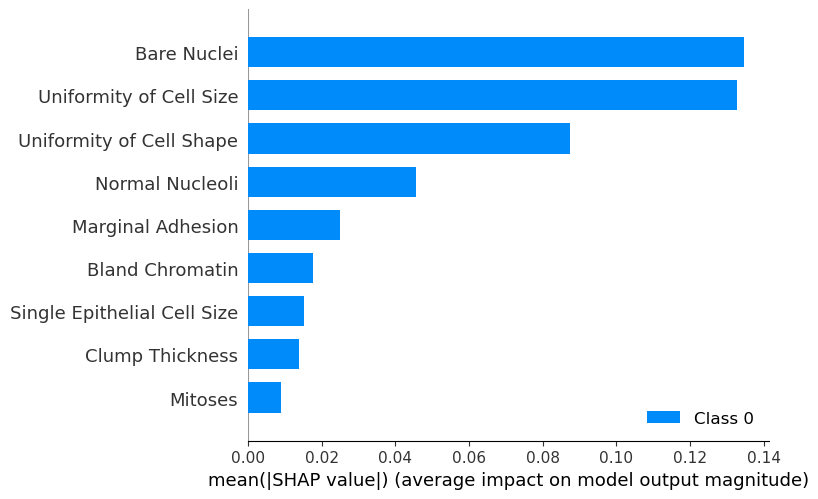

In [55]:
# SHAP is a Python package that allows us to explain the output of machine learning models.
import shap
from shap import KernelExplainer
explainer = KernelExplainer(final_model, shap.sample(x_train, 100))
shap_values = explainer.shap_values(x_train)
shap.summary_plot(shap_values, x_train, plot_type="bar")


### Analyzing the model using ELI5

In [13]:
# ELI5 is another Python package that allows us to explain the output of machine learning models.
# The difference between SHAP nd ELI5 is that SHAP is a game theoretic approach while ELI5 is a permutation approach.
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from keras.models import clone_model

class KerasClassifierWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        pass  # Already trained
    def predict(self, X):
        return np.round(self.model.predict(X))
    def score(self, X, y):
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)

wrapped_model = KerasClassifierWrapper(final_model)
perm = PermutationImportance(wrapped_model, random_state=1).fit(x_test, y_test, verbose=0)
eli5.show_weights(perm, feature_names=col_names[1:-1])

5/5 [==============================] - 0s 1ms/step


Weight,Feature
0.1643 ± 0.0626,Bare Nuclei
0.0557 ± 0.0140,Marginal Adhesion
0.0343 ± 0.0210,Uniformity of Cell Size
0.0229 ± 0.0107,Uniformity of Cell Shape
0.0071 ± 0.0000,Normal Nucleoli
0.0057 ± 0.0057,Bland Chromatin
0.0057 ± 0.0057,Clump Thickness
0 ± 0.0000,Mitoses
-0.0014 ± 0.0107,Single Epithelial Cell Size
